<a href="https://colab.research.google.com/github/AdrianPauer/MVOdata2023/blob/main/MVO_MMOLAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moja mama optimalizuje lepšie ako tvoja : LOG REGRESIA 2023


## 1 Ťahanie Dát

In [10]:
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import OptimizeResult

In [11]:
!git clone https://github.com/AdrianPauer/MVOdata2023
table = pd.read_csv("MVOdata2023/credit_risk_train.csv",sep = ';')
table_test = pd.read_csv("MVOdata2023/credit_risk_test.csv",sep = ';')
table

fatal: destination path 'MVOdata2023' already exists and is not an empty directory.


,Creditability,Duration of Credit (month),Value Savings/Stocks,Length of current employment
0,0,24,1,2
1,0,36,1,5
2,0,6,4,2
3,0,12,1,3
4,0,24,3,5
...,...,...,...,...
694,0,20,1,3
695,0,9,1,3
696,0,18,1,5
697,0,24,1,2


## 2.1 Príprava na testovanie metód

### 2.1.1 Účelové funkcie 
Task A,B



In [3]:
def J(x):
  sum = 0
  for index,row in table.iterrows():
    v = row[0]
    u = np.array(row[1:])
    x_u = x@u
    sum += x_u * (1-v) +  np.log(1 + np.exp(-x_u))
  return sum

def dfJ(x):
  sum = np.zeros_like(x)
  for index,row in table.iterrows():
    v = row[0]
    u = np.array(row[1:])
    x_u = x@u
    sum += u * (1-v) - (np.exp(-x_u)/(1 + np.exp(-x_u))) * u
  return sum 

##2.2 TaskC

###2.1.2 Metódy intervalovej aproximáci použité na hľadanie veľkosti kroku


In [4]:
def backtracking_line_search(fun, jac, x0, args=(), s=None, max_stepsize=1,
                             rho=0.1, c=0.05, options={}):
    """
    Implements the backtracking line search algorithm to find the step size alpha
    for gradient descent.

    Parameters:
        f : callable
            Objective function.
        g : callable
            Gradient function.
        x0 : array-like
            Current point.
        s : array-like, optional
            Search direction. If not provided, gradient direction is used.
        max_stepsize : numeric, optional.
            Initial step size. Default is 1.
        rho : numeric, optional
            Shrinkage factor. Nonnegative number, less than one. Default is 0.1.
        c : numeric, optional
            Armijo condition parameter. Default is 0.05.
        options : dict, optional
            A diactionary with solver options.
                maxiter : int
                    Maximum number of iterations to perform.

    Returns
    -------
        stepsize : float
            Step size that satisfies the Armijo condition.
    """

    assert 0 < rho < 1, "Rho parameter should be from range (0, 1)!"

    maxiter = options.get("maxiter", 100)

    x = np.array(x0)
    if s is None:
        s = -jac(x, *args)
        df_s = -s@s
    else:
        df_s = jac(x, *args) @ s
    
    stepsize = max_stepsize

    fx = fun(x, *args)
  
    
    for it in range(maxiter):
        if fun(x + stepsize*s, *args) > fx + c*stepsize*df_s:
            stepsize *= rho
        else:
            return stepsize
    
    return stepsize

In [5]:
def bisection(dfun, bounds=None, args=(), callback=None,
              options={}, **kwargs):
    """
    Minimization method

    Parameters
    ----------
    dfun : callable f(x, *args)
        Derivative of objective function to minimize.
    
    bounds : tuple of numeric sequence
        Two items corresponding to the optimization bounds.
    
    args : tuple, optional
        Extra arguments passed to the objective function.
    
    callback : callable f(x), optional
        Function called after each iteration.
    
    options : dict, optional
        A diactionary with solver options.
            maxiter : int
                Maximum number of iterations to perform.
            tol : float
                Tolerance for termination

    **kwargs : dict, optional
        Other parameters passed to `bisection`.

    Raises
    ------
    ValueError
        if `bounds` is not provided.

    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a OptimizeResult object.
        Important attributes are: x the solution,
        success a Boolean flag indicating if the optimizer exited successfully,
        message which describes the cause of the termination.
        See OptimizeResult for a description of other attributes.
    """
    
    if bounds is None:
        raise ValueError("Must provide `bounds` parameter!\n Tuple of numeric sequence: two items corresponding to the optimization bounds.")

    maxiter = options.get("maxiter", 1000)
    tol = options.get("tol", 1e-9)
    a, b = bounds

    for it in range(maxiter):
        c = (a+b)/2
        dfc = dfun(c, *args)
        if dfc > 0:
          b = c
        else:
          a = c
        if callback is not None:
            midpoint = (a+b) / 2
            callback(midpoint)
        
        if b - a < tol:
            break
    
    
    success = (b - a) < tol

    if success:
        msg = "Optimization successful"
    else:
        msg = "Optimization failed"
    
    return  OptimizeResult(x= (b+a)/2, nit=it, njev=it, tol=tol, success=success,message = msg) 

###BFGS


In [6]:
def bfgs(fun, jac, x0, stepsize_method, args=(), callback=None, options={}, **kwargs):
    """
    Minimization method

    Parameters
    ----------
    jac : callable f(x, *args)
        Gradient of objective function.
        
    x0 : array-like
        Initial guess. 
    
    args : tuple, optional
        Extra arguments passed to the `jac`.
    
    callback : callable f(x), optional
        Function called after each iteration.
    
    options : dict, optional
        A diactionary with solver options.
            maxiter : int
                Maximum number of iterations to perform. Default is 1000.
            tol : float
                Tolerance for termination. Default is 1e-8.
            H0 : array-like
                Initial approximation of inverse hessian. Default is
                identity matrix.
            max_stepsize: float
                Maximum step size for line search. Default is 10.

    **kwargs : dict, optional
        Other parameters passed to `bfgs`.


    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a OptimizeResult object.
        Important attributes are: x the solution,
        success a Boolean flag indicating if the optimizer exited successfully,
        message which describes the cause of the termination.
        See OptimizeResult for a description of other attributes.
    """

    x = np.array(x0)
    n = len(x)

    maxiter = options.get("maxiter", 1000)
    tol = options.get("tol", 1e-8)
    H = options.get("H0", np.eye(n))
    max_stepsize = options.get("max_stepsize", 10)

    g = jac(x, *args)
    for it in range(maxiter):
        s = -H @ g
        
        if stepsize_method == 'bisection':
          dzuzenie = lambda a : (jac(x + a*s, *args)) @ s
          stepsize = bisection(dzuzenie, bounds = (0,max_stepsize)).x
        elif stepsize_method == 'backtracking':
          stepsize = backtracking_line_search(fun,jac,x,args,max_stepsize = max_stepsize, s = s)
        else :
          print('Zadaj metodu')
      
        x_old = x.copy()
        g_old = g.copy()

      
        x = x + stepsize * s
        g = jac(x, *args)

        y = g - g_old
        p = x - x_old

        pTy = p@y
        Hy = H@y
      
        deltaH = (1 + ( (y@H@y) / pTy ) ) * (np.outer(p,p) / pTy) - ( ( np.outer(Hy, p) + (np.outer(p,y))@H) / pTy )
        
        H = H + deltaH

        if callback is not None:
            callback(x)
        
        if np.linalg.norm(jac(x, *args)) <= tol:
            break
    
    
    success = np.linalg.norm(jac(x, *args)) <= tol

    if success:
        msg = "Optimization successful"
    else:
        msg = "Optimization failed"
    
    return OptimizeResult(x = x, nit = it + 1, njev = it + 1, success = success, message = msg)


In [12]:
bfgs_iterations = []
fill_bgfs = lambda x: bfgs_iterations.append(x)
res_bfgs = bfgs(fun = J, jac=dfJ, x0 = np.zeros(3), stepsize_method = 'backtracking', callback=fill_bgfs, options = {'tol' : 1e-3})

<ipython-input-3-c3a199073459>:7: RuntimeWarning: overflow encountered in exp
  sum += x_u * (1-v) +  np.log(1 + np.exp(-x_u))


###2.2.2 dfp

In [8]:
def dfp (fun, jac, x0, stepsize_method, args=(), callback=None, options={}, **kwargs):
    """
    Minimization method

    Parameters
    ----------
    jac : callable f(x, *args)
        Gradient of objective function.
        
    x0 : array-like
        Initial guess. 
    
    args : tuple, optional
        Extra arguments passed to the `jac`.
    
    callback : callable f(x), optional
        Function called after each iteration.
    
    options : dict, optional
        A diactionary with solver options.
            maxiter : int
                Maximum number of iterations to perform. Default is 1000.
            tol : float
                Tolerance for termination. Default is 1e-8.
            H0 : array-like
                Initial approximation of inverse hessian. Default is
                identity matrix.
            max_stepsize: float
                Maximum step size for line search. Default is 10.

    **kwargs : dict, optional
        Other parameters passed to `bfgs`.


    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a OptimizeResult object.
        Important attributes are: x the solution,
        success a Boolean flag indicating if the optimizer exited successfully,
        message which describes the cause of the termination.
        See OptimizeResult for a description of other attributes.
    """

    x = np.array(x0)
    n = len(x)

    maxiter = options.get("maxiter", 1000)
    tol = options.get("tol", 1e-8)
    H = options.get("H0", np.eye(n))
    max_stepsize = options.get("max_stepsize", 10)

    g = jac(x, *args)
    for it in range(maxiter):
        s = -H @ g

        if stepsize_method == 'bisection':
          dzuzenie = lambda a : (jac(x + a*s, *args)) @ s
          stepsize = bisection(dzuzenie, bounds = (0,max_stepsize)).x
        elif stepsize_method == 'backtracking':
          stepsize = backtracking_line_search(fun,jac,x,args,max_stepsize = max_stepsize, s = s)
        else :
          print('Zadaj metodu')
        
        x_old = x.copy()
        g_old = g.copy()

        x = x + stepsize * s
        g = jac(x, *args)

        y = g - g_old
        p = x - x_old

        Hy = H@y

    
        deltaH = ( np.outer(p,p) / (p@y) ) - ( np.outer(Hy,y@H) / (y@Hy) )  

        H = H + deltaH

        if callback is not None:
            callback(x)
        
        if np.linalg.norm(jac(x,*args)) < tol:
            break
    
    
    success = np.linalg.norm(jac(x, *args)) < tol

    if success:
        msg = "Optimization successful"
    else:
        msg = "Optimization failed"
    
    return OptimizeResult(x = x, nit = it + 1, njev = it + 1, success = success, message = msg)

In [13]:
dfp_iterations = []
fill_dfp = lambda x: dfp_iterations.append(x)
res_dfp = dfp(fun = J, jac=dfJ, x0 = np.zeros(3), stepsize_method='backtracking', callback=fill_dfp, options = {'tol' : 1e-3})


<ipython-input-3-c3a199073459>:7: RuntimeWarning: overflow encountered in exp
  sum += x_u * (1-v) +  np.log(1 + np.exp(-x_u))


##2.3 TaskD

In [14]:
import time
for step_method in 'bisection','backtracking':
  start = time.time()
  max_step = 10
  if step_method == 'bisection':
    max_step = 0.5
  result = bfgs(fun = J, jac=dfJ, x0 = np.zeros(3), stepsize_method=step_method, callback=fill_bgfs, options = {'tol' : 1e-3,'max_stepsize' : max_step})
  print(f'bfgs with {step_method}: x:{result.x}\n message:{result.message} \n success={result.success} \n nits={result.nit} \n time: {time.time()-start}')
  start = time.time()
  result = dfp(fun = J, jac=dfJ, x0 = np.zeros(3), stepsize_method=step_method, callback=fill_dfp, options = {'tol' : 1e-3, 'max_stepsize' : max_step})
  print(f'dfp with {step_method}: x:{result.x}\n message:{result.message} \n success={result.success} \n nits={result.nit} \n time: {time.time()-start}')
     

bfgs with bisection: x:[-0.04536012  0.32766542  0.34624637]
 message:Optimization successful 
 success=True 
 nits=22 
 time: 57.646259784698486
dfp with bisection: x:[-0.04536012  0.32766541  0.34624637]
 message:Optimization successful 
 success=True 
 nits=22 
 time: 62.58864879608154


<ipython-input-3-c3a199073459>:7: RuntimeWarning: overflow encountered in exp
  sum += x_u * (1-v) +  np.log(1 + np.exp(-x_u))


bfgs with backtracking: x:[-0.04536027  0.32766468  0.34624817]
 message:Optimization successful 
 success=True 
 nits=8 
 time: 5.078758001327515
dfp with backtracking: x:[-0.04536013  0.32766552  0.34624645]
 message:Optimization successful 
 success=True 
 nits=9 
 time: 5.270711183547974


## 2.4 TaskE

In [15]:
def sr1(fun, jac, stepsize_method, x0, args=(), callback=None, options={}, **kwargs):
    x = np.array(x0)
    n = len(x)

    maxiter = options.get("maxiter", 10000)
    tol = options.get("tol", 1e-5)
    H = options.get("H0", np.eye(n))
    max_stepsize = options.get("max_stepsize", 10)

    g = jac(x, *args)
    for it in range(maxiter):
        s = -H @ g
        dzuzenie = lambda a : (jac(x + a*s, *args)) @ s
        if stepsize_method == 'bisection':
            stepsize = bisection(dzuzenie, bounds = (0,max_stepsize)).x
        elif stepsize_method == 'backtracking':
            stepsize = backtracking_line_search(fun,jac,x,args,max_stepsize = max_stepsize, s = s)

        
        x_old = x.copy()
        g_old = g.copy()

        x = x + stepsize * s
        g = jac(x, *args)

        y = g - g_old
        p = x - x_old

        pHy = p - H@y
        deltaH = np.outer(pHy, pHy) / (y @ (pHy))  

        H = H + deltaH

        if callback is not None:
            callback(x)
        
        if np.linalg.norm(jac(x ,*args)) < tol:
            break
    
    
    success = np.linalg.norm(jac(x, *args)) < tol

    if success:
        msg = "Optimization successful"
    else:
        msg = "Optimization failed"
    
    return OptimizeResult(x = x, nit = it + 1, njev = it + 1, success = success, message = msg)

sr1 bisection
sr1 backtracking


<ipython-input-3-c3a199073459>:7: RuntimeWarning: overflow encountered in exp
  sum += x_u * (1-v) +  np.log(1 + np.exp(-x_u))


dfp bisection
dfp backtracking
bfgs bisection
bfgs backtracking


Text(0, 0.5, 'Difference')

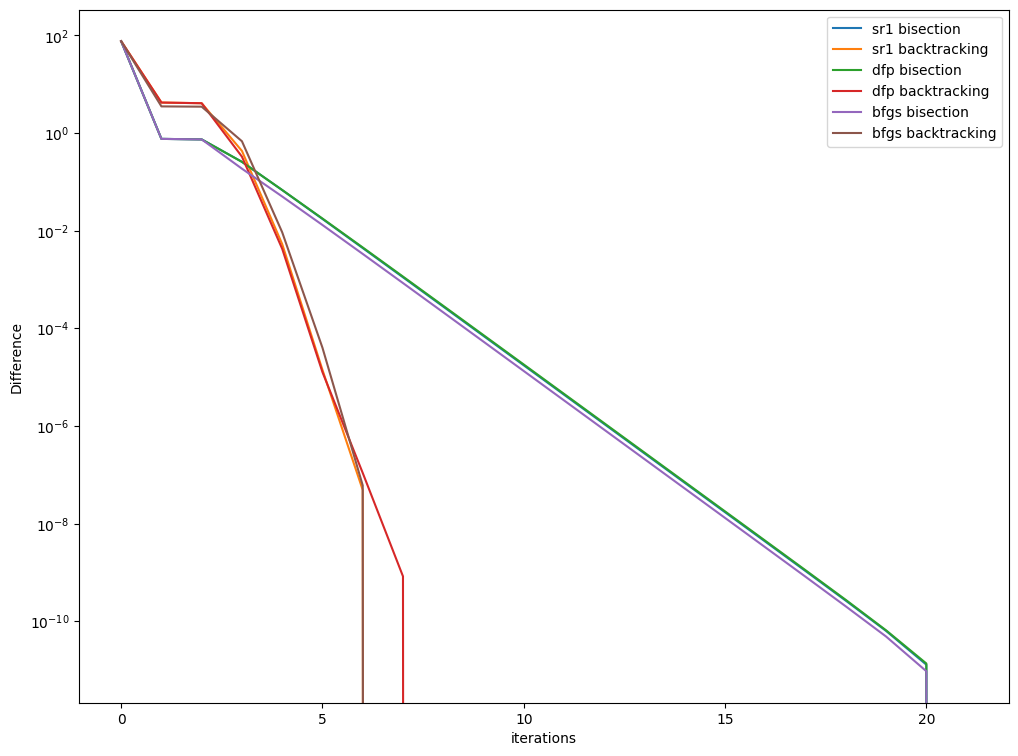

In [16]:
import matplotlib.pyplot as plt

methods = [sr1, dfp, bfgs]

zobraz = []
for i in range(len(methods)):  
    for met in ['bisection', 'backtracking']:
        print(methods[i].__name__ + " " + met)
        iterations = []
        fill = lambda x: iterations.append(J(x))
        if (met == 'backtracking'):
            methods[i](fun = J, jac=dfJ, stepsize_method = met, x0 = np.zeros(3), callback=fill, options = {'tol' : 1e-3})
        else:
            methods[i](fun = J, jac=dfJ, stepsize_method = met, x0 = np.zeros(3), callback=fill, options = {'tol' : 1e-3, 'max_stepsize': 0.5})
        zobraz.append((methods[i].__name__ + " " + met, [x - iterations[-1] for x in iterations]))

plt.figure(figsize = (12, 9))
for i in zobraz:
    plt.plot(i[1], label = i[0])
    
    
plt.legend()
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Difference')

## 2.5 TaskF

In [17]:
def grad_const(jac, x0=None, args=(), callback=None,
              options={}, **kwargs):
    """
    Minimization method

    Parameters
    ----------
    jac : callable f(x, *args)
        Gradient of objective function.
        
    x0 : array-like
        Initial guess. 
    
    args : tuple, optional
        Extra arguments passed to the `jac`.
    
    callback : callable f(x), optional
        Function called after each iteration.
    
    options : dict, optional
        A diactionary with solver options.
            maxiter : int
                Maximum number of iterations to perform.
            tol : float
                Tolerance for termination.
            stepsize : float
                Factor for calculatng step in one iteration.

    **kwargs : dict, optional
        Other parameters passed to `grad_const`.

    Raises
    ------
    ValueError
        if `x0` is not provided.

    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a OptimizeResult object.
        Important attributes are: x the solution,
        success a Boolean flag indicating if the optimizer exited successfully,
        message which describes the cause of the termination.
        See OptimizeResult for a description of other attributes.
    """
    
    if x0 is None:
        raise ValueError("Must provide initial guess `x0`!")

    maxiter = options.get("maxiter", 1000)
    tol = options.get("tol", 1e-6)
    stepsize = options.get("stepsize", 1e-5)
    x = np.array(x0)

    for it in range(maxiter):
        x = x - stepsize * jac(x, *args)

        if callback is not None:
            callback(x)
        
        if np.linalg.norm(jac(x, *args)) < tol:
            break
    
    
    success = np.linalg.norm(jac(x, *args)) < tol

    if success:
        msg = "Optimization successful"
    else:
        msg = "Optimization failed"
    
    return OptimizeResult(x = x, success = success, status = msg, nit = it, njev = it)

def backtracking_line_search(fun, jac, x0, args=(), s=None, max_stepsize=1,
                             rho=0.1, c=0.05, options={}):
    """
    Implements the backtracking line search algorithm to find the step size alpha
    for gradient descent.

    Parameters:
        f : callable
            Objective function.
        g : callable
            Gradient function.
        x0 : array-like
            Current point.
        s : array-like, optional
            Search direction. If not provided, gradient direction is used.
        max_stepsize : numeric, optional.
            Initial step size. Default is 1.
        rho : numeric, optional
            Shrinkage factor. Nonnegative number, less than one. Default is 0.1.
        c : numeric, optional
            Armijo condition parameter. Default is 0.05.
        options : dict, optional
            A diactionary with solver options.
                maxiter : int
                    Maximum number of iterations to perform.

    Returns
    -------
        stepsize : float
            Step size that satisfies the Armijo condition.
    """

    assert 0 < rho < 1, "Rho parameter should be from range (0, 1)!"

    maxiter = options.get("maxiter", 100)

    x = np.array(x0)
    if s is None:
        s = -jac(x, *args)
        df_s = -s@s
    else:
        df_s = jac(x, *args) @ s
    
    stepsize = max_stepsize

    fx = fun(x, *args)
    
    
    for it in range(maxiter):
        if fun(x + stepsize*s, *args) > fx + c*stepsize*df_s:
            stepsize *= rho
        else:
            return stepsize
    
    return stepsize

def backtrack(fun, jac, x0=None, args=(), callback=None,
              options={}, **kwargs):
    """
    Minimization method

    Parameters
    ----------
    jac : callable f(x, *args)
        Gradient of objective function.
        
    x0 : array-like
        Initial guess. 
    
    args : tuple, optional
        Extra arguments passed to the `jac`.
    
    callback : callable f(x), optional
        Function called after each iteration.
    
    options : dict, optional
        A diactionary with solver options.
            maxiter : int
                Maximum number of iterations to perform.
            tol : float
                Tolerance for termination

    **kwargs : dict, optional
        Other parameters passed to `cauchy`.

    Raises
    ------
    ValueError
        if `x0` is not provided.

    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a OptimizeResult object.
        Important attributes are: x the solution,
        success a Boolean flag indicating if the optimizer exited successfully,
        message which describes the cause of the termination.
        See OptimizeResult for a description of other attributes.
    """
    
    if x0 is None:
        raise ValueError("Must provide initial guess `x0`!")

    maxiter = options.get("maxiter", 1000)
    tol = options.get("tol", 1e-8)
    stepsize = options.get("stepsize", 1e-5)

    maxiter_step_search = options.get("maxiter_step_search", 100)
    rho = options.get("rho", 0.5)
    c = options.get("c", 1e-4)

    x = np.array(x0)

    for it in range(maxiter):
        s = -jac(x, *args)
        alpha = backtracking_line_search(fun, jac, x, args, max_stepsize = stepsize, s = s)
        x_new = x + s * alpha

        if callback is not None:
            callback(x)
        
        if np.linalg.norm(x_new - x) < tol:
            break
        
        x = x_new
    
    
    success = np.linalg.norm(x_new - x) < tol

    if success:
        msg = "Optimization successful"
    else:
        msg = "Optimization failed"
    
    return OptimizeResult(x = x, nit = it, njev = it, success = success, message = msg)

def nester(jac, beta=0.2, x0=None, args=(), callback=None,
              options={}, **kwargs):
    """
    Minimization method

    Parameters
    ----------
    jac : callable f(x, *args)
        Gradient of objective function.
        
    x0 : array-like
        Initial guess. 
    
    beta : parameter Beta in Nester method

    args : tuple, optional
        Extra arguments passed to the `jac`.
    
    callback : callable f(x), optional
        Function called after each iteration.
    
    options : dict, optional
        A diactionary with solver options.
            maxiter : int
                Maximum number of iterations to perform.
            tol : float
                Tolerance for termination.
            stepsize : float
                Factor for calculatng step in one iteration.

    **kwargs : dict, optional
        Other parameters passed to `grad_const`.

    Raises
    ------
    ValueError
        if `x0` is not provided.

    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a OptimizeResult object.
        Important attributes are: x the solution,
        success a Boolean flag indicating if the optimizer exited successfully,
        message which describes the cause of the termination.
        See OptimizeResult for a description of other attributes.
    """
    
    if x0 is None:
        raise ValueError("Must provide initial guess `x0`!")

    maxiter = options.get("maxiter", 1000)
    tol = options.get("tol", 1e-6)
    stepsize = options.get("stepsize", 1e-5)

    x = np.array(x0)
    v = 0
    for it in range(1, maxiter):
      s = -jac(x,*args)
      v = beta * v + s * stepsize
      x = x + v
      
      if callback is not None:
          callback(x)
      if np.linalg.norm(jac(x, *args)) < tol:
          break
    
    
    success = np.linalg.norm(jac(x, *args)) < tol

    if success:
        msg = "Optimization successful"
    else:
        msg = "Optimization failed"
    
    return OptimizeResult(x = x, nit = it,njev = it, success = success, message = msg)
  
def cauchy(fun, jac, x0=None, args=(), callback=None,
              options={}, **kwargs):
    """
    Minimization method

    Parameters
    ----------
    jac : callable f(x, *args)
        Gradient of objective function.
        
    x0 : array-like
        Initial guess. 
    
    args : tuple, optional
        Extra arguments passed to the `jac`.
    
    callback : callable f(x), optional
        Function called after each iteration.
    
    options : dict, optional
        A diactionary with solver options.
            maxiter : int
                Maximum number of iterations to perform.
            tol : float
                Tolerance for termination
            max_stepsize : float
                Maximum stap size allowed.

    **kwargs : dict, optional
        Other parameters passed to `cauchy`.

    Raises
    ------
    ValueError
        if `x0` is not provided.

    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a OptimizeResult object.
        Important attributes are: x the solution,
        success a Boolean flag indicating if the optimizer exited successfully,
        message which describes the cause of the termination.
        See OptimizeResult for a description of other attributes.
    """
    
    if x0 is None:
        raise ValueError("Must provide initial guess `x0`!")

    maxiter = options.get("maxiter", 1000)
    tol = options.get("tol", 1e-8)
    max_stepsize = options.get("stepsize", 1)

    x = np.array(x0)
    nj = 0
    for it in range(maxiter):
        s = -jac(x, *args)
        dzuzenie = lambda a : (jac(x + a*s, *args)) @ s
        stepsize = bisection(dzuzenie, bounds = (0,max_stepsize)).x
        nj += 1
        x = x + stepsize * s
        if callback is not None:
            callback(x)
        
        if np.linalg.norm(jac(x, *args)) < tol:
            break
    
    
    success = np.linalg.norm(jac(x, *args)) < tol

    if success:
        msg = "Optimization successful"
    else:
        msg = "Optimization failed"
    
    return OptimizeResult(x = x, success = success, status = msg, nit = it, njev = nj)
    

nester
backtrack
grad_const
cauchy


Text(0, 0.5, 'Difference')

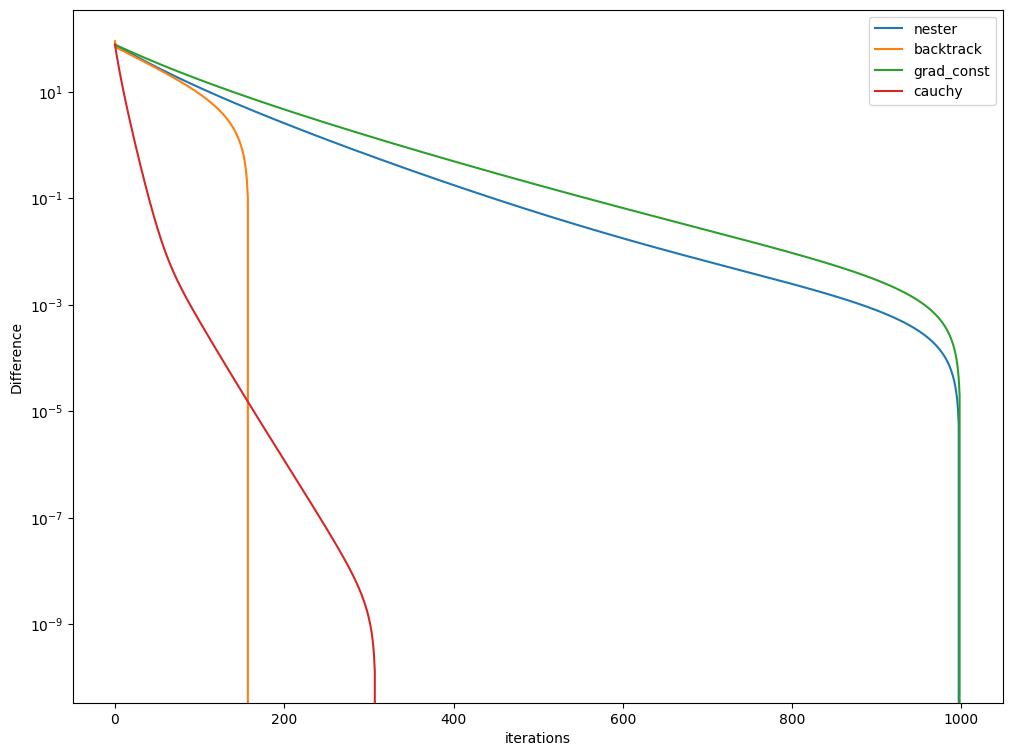

In [18]:
methods = [nester, backtrack, grad_const, cauchy]


zobraz = []
for i in range(len(methods)):  
    print(methods[i].__name__)
    iterations = []
    fill = lambda x: iterations.append(J(x))  
    if (methods[i] == cauchy):
        methods[i](fun = J, jac=dfJ, x0 = np.zeros(3), callback=fill, options = {'tol' : 1e-3, 'stepsize': 0.05})
    else:    
        methods[i](fun = J, jac=dfJ, x0 = np.zeros(3), callback=fill, options = {'tol' : 1e-3})
    zobraz.append((methods[i].__name__, [x - iterations[-1] for x in iterations]))

plt.figure(figsize = (12, 9))
for i in zobraz:
    plt.plot(i[1], label = i[0])
    
    
plt.legend()
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Difference')

## 2.6 TaskG

In [19]:
bfgs_bis_iterations = []
fill_bgfs_bis = lambda x: bfgs_bis_iterations.append(x)
res_bfgs_bis = bfgs(fun = J, jac=dfJ, x0 = np.zeros(3), stepsize_method='bisection', callback=fill_bgfs_bis, options = {'tol' : 1e-3,'max_stepsize' : 0.5})

In [20]:
is_solv = lambda u,x: 1/(1 + np.exp(-x.T@u)) > .5

df = pd.DataFrame(table_test)

us = [{'u':( #1, 
            u['Duration of Credit (month)'], #u1
            u['Value Savings/Stocks'], #u2
            u['Length of current employment']), #u3
      'expec':u['Creditability'] #expected
            } for ind,u in df.iterrows()]

results_dfp = np.array([is_solv(u['u'], res_dfp.x) == u['expec'] for u in us])

results_bfgs = np.array([is_solv(u['u'], res_bfgs.x) == u['expec'] for u in us])

results_bfgs_bis = np.array([is_solv(u['u'], res_bfgs_bis.x) == u['expec'] for u in us])


compare_table = pd.DataFrame({'Method':[
                                        'BFGS', 
                                        'DFP',
                                        'BFGS(bisection for stepsize)'], 
                              'Found x':[ 
                                        res_bfgs.x, 
                                        res_dfp.x,
                                        res_bfgs_bis.x], 
                              'Success rate':[  
                                        sum(results_dfp)/len(results_dfp), 
                                        sum(results_bfgs)/len(results_bfgs),
                                        sum(results_bfgs_bis)/len(results_bfgs_bis)]
                              })

compare_table


,Method,Found x,Success rate
0,BFGS,"[-0.045360269954120055, 0.32766468245074293, 0...",0.714286
1,DFP,"[-0.04536012743044241, 0.3276655150077976, 0.3...",0.714286
2,BFGS(bisection for stepsize),"[-0.045360119681680064, 0.3276654205655734, 0....",0.714286


## 2.7 Task H

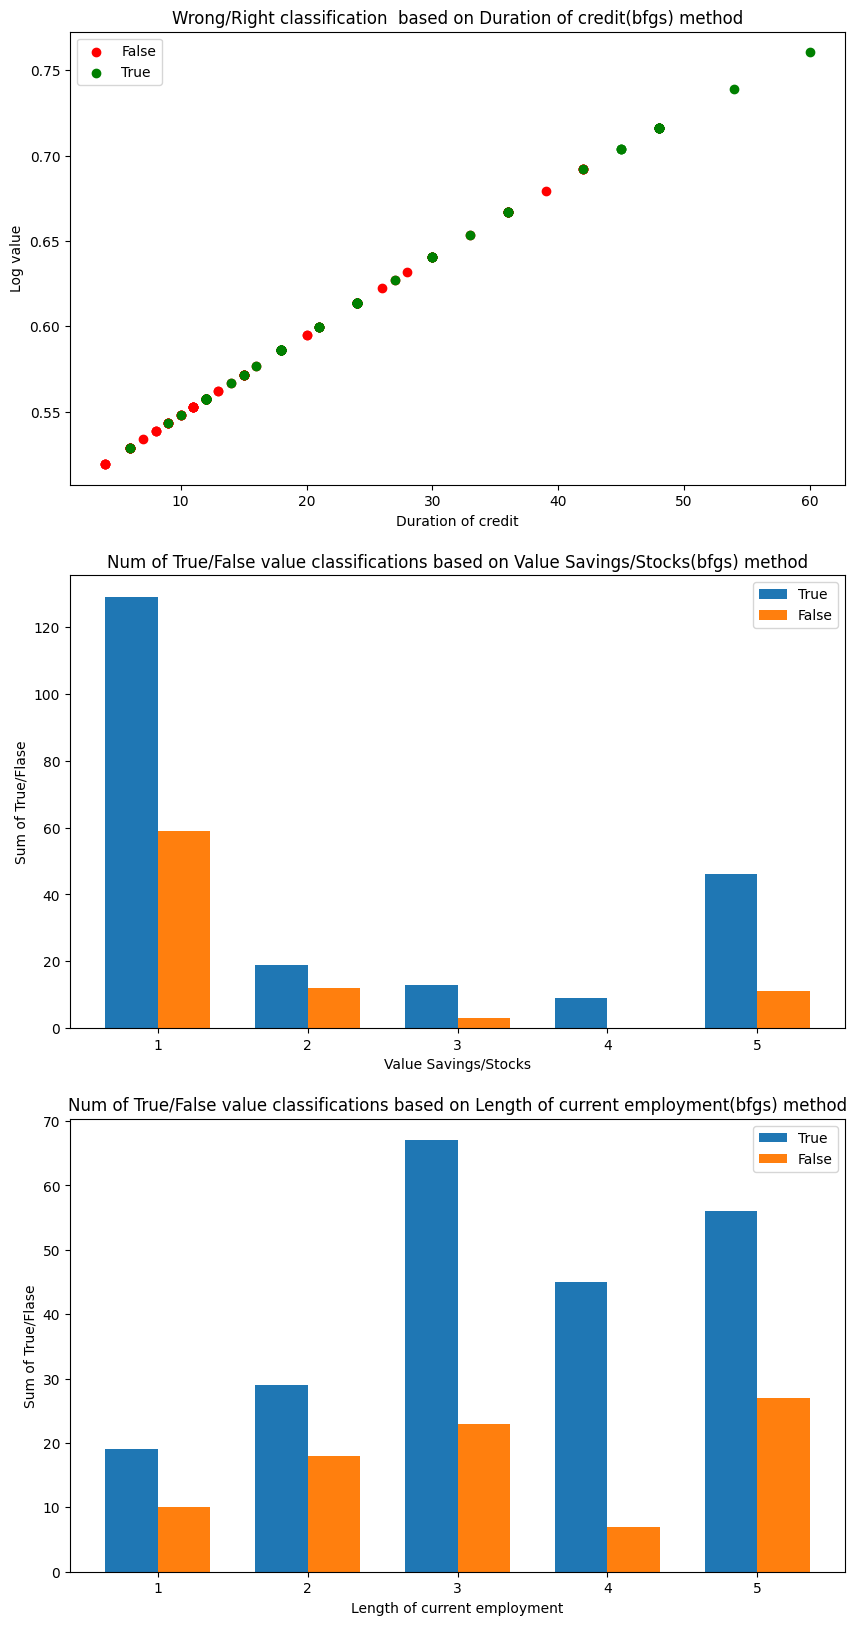

In [21]:
is_solv = lambda u,x: 1/(1 + np.exp(-x.T@[u])) > .5


def JJ(x,i = 0):
  sum = 0
  for index,row in table.iterrows():
    v = row[0]
    u = np.array([row[i]])
    x_u = x@u
    sum += x_u * (1-v) +  np.log(1 + np.exp(-x_u))
  return sum

def dfJJ(x,i = 0):
  sum = np.zeros_like(x)
  for index,row in table.iterrows():
    v = row[0]
    u = np.array([row[i]])
    x_u = x@u
    sum += u * (1-v) - (np.exp(-x_u)/(1 + np.exp(-x_u))) * u
  return sum 


df = pd.DataFrame(table_test)

us3 = [{'u':(
            u['Length of current employment']), #u3
      'expec':u['Creditability'] #expected
            } for ind,u in df.iterrows()]

us1 = [{'u':( #1, 
            u['Duration of Credit (month)']), #u1
      'expec':u['Creditability'] #expected
            } for ind,u in df.iterrows()]

us2 = [{'u':( #1, 
            u['Value Savings/Stocks']), #u2
      'expec':u['Creditability'] #expected
            } for ind,u in df.iterrows()]

     

def plot1():
  y = np.array([u['u'] for u in us1])

  axes[0].scatter(y[resultsu], x[resultsu], color='red', label='False')
  axes[0].scatter(y[~resultsu], x[~resultsu], color='green', label='True')

  axes[0].set_title(f'Wrong/Right classification  based on {uis[0]}(bfgs) method')
  axes[0].set_xlabel(uis[0])
  axes[0].set_ylabel('Log value')
  axes[0].legend()

def plot2(i):
  y = np.array([u['u'] for u in us2])
  true_values = [data[i][True] for i in range(1, 6)]
  false_values = [data[i][False] for i in range(1, 6)]
  axes[i].bar(range(1, 6), true_values, width = 0.35,label="True")
  axes[i].bar([x + 0.35 for x in range(1,6)], false_values, width=0.35, label='False')
  axes[i].set_xticks([x + 0.35/2 for x in range(1,6)])
  axes[i].set_xticklabels(range(1,6))
  axes[i].set_title(f'Num of True/False value classifications based on {uis[i]}(bfgs) method')
  axes[i].set_xlabel(uis[i])
  axes[i].set_ylabel('Sum of True/Flase')
  axes[i].legend()


figure,axes = plt.subplots(nrows = 3,ncols =1 ,figsize = (10,20))
solvable = lambda u,x: 1/(1 + np.exp(-x.T@[u]))
i = 0
uis = {0:'Duration of credit',1:'Value Savings/Stocks',2:'Length of current employment'}

res_bfgs = bfgs(fun = JJ, jac=dfJJ, x0 = np.zeros(1), stepsize_method='backtracking',args=(i+1,), callback=fill_bgfs, options = {'tol' : 1e-3,'max_stepsize' : 0.5})
resultsu = np.array([is_solv(u['u'], res_bfgs.x) == u['expec'] for u in us1])
x = np.array([solvable(u['u'], res_bfgs.x) for u in us1])
plot1()

i+=1

def nulldict():
  data = {
      1: {True: 0, False: 0},
      2: {True: 0, False: 0},
      3: {True: 0, False: 0},
      4: {True: 0, False: 0},
      5: {True: 0, False: 0}
  }
  # return {i:{True:0, False:0} for i in range(1,6)}
  return data


for ut in us2,us3:
  res_bfgs = bfgs(fun = JJ, jac=dfJJ, x0 = np.zeros(1), stepsize_method='backtracking',args=(i+1,), callback=fill_bgfs, options = {'tol' : 1e-3,'max_stepsize' : 0.5})
  data = nulldict()
  for u in ut:
    data[u['u']][is_solv(u['u'], res_bfgs.x) == u['expec']] += 1
  resultsu = np.array([is_solv(u['u'], res_bfgs.x) == u['expec'] for u in ut])
  plot2(i)
  i+=1

plt.show()
     
